In [1]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_spec, print_spec
from wlenet.dataset.io import load_sim, load_target
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps
from wlenet.models.figures import show_scatter_label_pred, show_first_conv_kernels
from wlenet.models.predict import predict, predict_test_time_aug

/Users/ofer/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model_spec = load_spec('cnn_image_clash_uniform_mse')
model_spec['kwargs_dataset']['sim_names_test'] = ['clash_003_test']
save_calib = True

In [3]:
print_spec(model_spec)

{'arch_name': 'cnn_image',
 'calib': (-0.0001000689577741915, -0.803380112608412, 0.00010982549604553951, -0.8028322997331188),
 'kwargs_arch': {'dropout_dense_rate': 0.3, 'out_dim': 2, 'use_discriminator': False, 'use_dropout_dense': True},
 'kwargs_dataset': {'noise_kernel_factor': 1.0,
                    'noise_kernel_name': 'clash',
                    'post_sim': {'flux_cut_min': -inf, 'flux_factor': 0.32, 'intensity_cutoff': 0.012},
                    'sim_names_test': ['clash_003_test'],
                    'sim_names_train': ['low_002', 'med_002', 'hig_002', 'low_004', 'med_004', 'hig_004'],
                    'target_header_path': None},
 'kwargs_train': {'epochs': 100, 'label_loss': 'mean_squared_error', 'patience': 10},
 'trained_name': 'cnn_image_clash_uniform_mse'}


In [4]:
model = load_model(model_spec, load_weights=True, show_summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 10, 10, 64)        1664      
_________________________________________________________________
conv_2 (Conv2D)              (None, 10, 10, 40)        2600      
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 10, 10)        410       
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

In [5]:
noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
post_sim = model_spec['kwargs_dataset']['post_sim'] if 'post_sim' in model_spec['kwargs_dataset'] else None
output_dim = get_output_dim(model)

source_test = dict(zip(('x', 'y'), load_sim(model_spec['kwargs_dataset']['sim_names_test'], 'test', output_dim, post_sim=post_sim)))
target_test, _ = load_target(model_spec['kwargs_dataset']['target_header_path'])

seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, target=target_test)

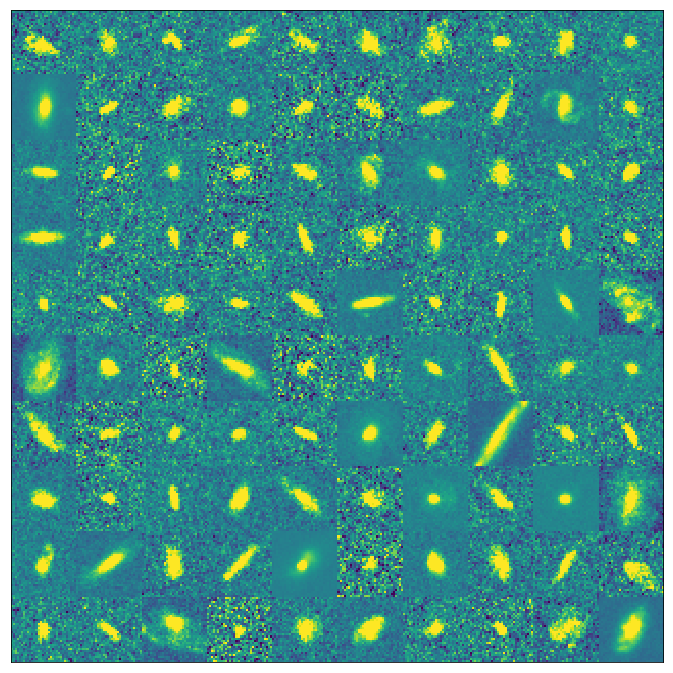

In [6]:
show_stamps(generate_batches(seq_test, 1)[0])

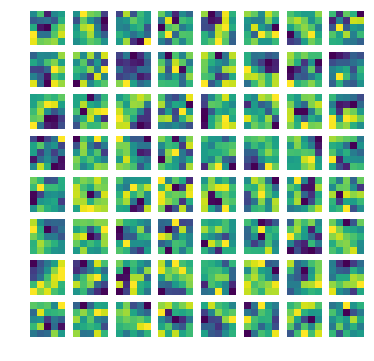

In [7]:
show_first_conv_kernels(model)

In [8]:
from wlenet.dataset.normalization import norm_mean_std

seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, norm_func=None)
x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq_test, 1000)

step biases c1: 0.000, m1: -0.801, c2: -0.000, m2: -0.804
rmse1: 0.222, rmse2: 0.224, (rmse1 + rmse2)/2: 0.223


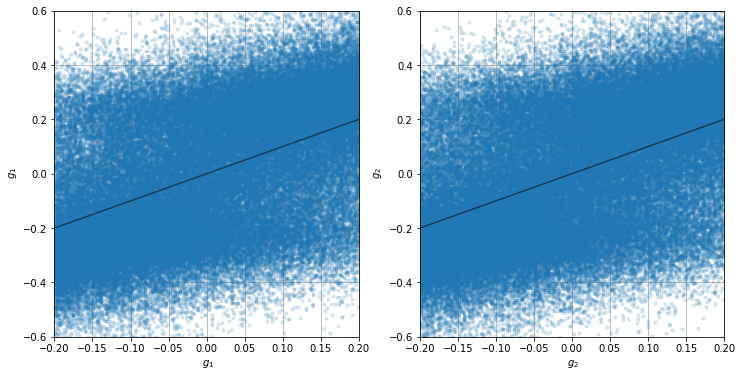

In [9]:
y_seq_ptta = predict_test_time_aug(norm_mean_std(x_seq_test), model)
y_seq_ptta, calib_ptta, rmse_ptta = step_bias_calib(y_seq_test, y_seq_ptta, verbose=True)
show_scatter_label_pred(y_seq_test, y_seq_ptta, min_g=-0.6, max_g=0.6, min_g_true=-0.2, max_g_true=0.2)

In [10]:
model_spec['calib'] = calib_ptta
if save_calib:
    save_spec(model_spec)